In [2]:
# Starting with the easy stuff, parsing the image labels
with open("./data/train-labels-idx1-ubyte", 'rb') as label_file:
    # See http://yann.lecun.com/exdb/mnist/#:~:text=TRAINING%20SET%20IMAGE%20FILE%20(train%2Dimages%2Didx3%2Dubyte)%3A for full     #  schema
    # Basically, bytes [0,4) are magic number, [4,8) are the number of labels, and each byte after that is a label (0-9).
    label_file.seek(4)
    num_labels = label_file.read(4)
    num_labels = int.from_bytes(num_labels, "big")
    labels = []
    for _ in range(num_labels):
        label = int.from_bytes(label_file.read(1), "big")
        labels.append(label)
    
    assert len(labels) == num_labels  # Just to make sure we did everything right


In [62]:

# Okay. Let's read the images in. I'm going to start with just one, so we can test out our logic before looping through 60000 images. Here's what we know about the schema: bytes [0,4) are the magic number. Bytes [4,8) are the number of images. Bytes [8,12) are the number of rows, and bytes [12,16) are the number of columns. After that, each byte is a pixel. I got all of this from http://yann.lecun.com/exdb/mnist/#:~:text=TRAINING%20SET%20IMAGE%20FILE%20(train%2Dimages%2Didx3%2Dubyte)%3A. Oh, and the pixels are stored row_wise. Oh, and the are MSB ordered.

ORDERING = "big"  # We're going to have to use this a lot

images_file = open("./data/train-images-idx3-ubyte", 'rb')
images_file.seek(4)  # skip the magic number
num_images = int.from_bytes(images_file.read(4), ORDERING)
num_rows = int.from_bytes(images_file.read(4), ORDERING)
num_cols = int.from_bytes(images_file.read(4), ORDERING)

# We can devise a pretty easy assertion to see if our numbers are right. If there are n images, h rows per image, w columns per image, and images are stored row_wise, then there should be n*h*w bytes remaining after we've read the first 16

# Uncomment the lines below if you are not familiar with python file methods (I needed a refresher)
#help(images_file.seek)
#help(images_file.tell)

cur_loc = images_file.tell()  # This should be 16, but maybe the file organization will change by the time you're reading this
assert num_images * num_rows * num_cols == images_file.seek(0,2) - cur_loc

# Okay, hopefully that passed on your machine. It did on mine.
# Now, let's read just a single image and try and display it. This will gives us the confidence we need before reading 60000 of # them. As an added bonus, we can check the label of the image and see if it matches.
# Remember, the images are stored in row_order. So we read num_cols bytes num_rows times to read a full image

import numpy as np
# We're going to read the first image. 
images_file.seek(cur_loc, 0) # reset ourselves
image = np.array([])
for _ in range(num_rows):
    row = images_file.read(num_cols)
    row = list(row)
    image = np.append(image, np.array(row))

image = np.reshape(image, (28, 28))
images_file.close()

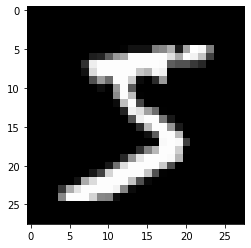

In [69]:
## Alright, so we image our "image" now. Let's try to visualize it
import matplotlib.pyplot as plt
plt.imshow(image, cmap='gray')
plt.show()
# WooHoo! that looks like a number to me! and for good measure, let's check the label as well:
image_vectors = np.array(image)
trans = np.array([[0, -1], [1,0]])
new_image = np.ndarray((28,28))
for i, vec in enumerate(image_vectors):
    for j, p in enumerate(vec):
        new_loc_i = i * trans[0][0] + j * trans[0][1]
        new_loc_j = i * trans[1][0] + j * trans[1][1]
        new_image[new_loc_i][new_loc_j] = p

[[ 0 -1]
 [ 1  0]]


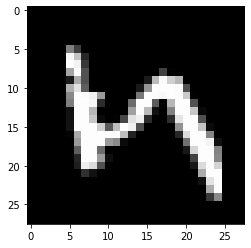

In [70]:
print(trans)
plt.imshow(new_image, cmap='gray')

In [5]:
# Alright friends. I think we're in a good place to read in all our images. Let's write a for loop to do so. But first, a quick note:

# This line up above may have given you pause: image = np.reshape(image, (28, 28)). I can see two main reasons why you'd ponder this line: 
# 1) You're wondering what this method does and why we need it
# 2) You've realized that this makes our per_row loop unneccessary

# If you're part of group 2, then just know you're correct. If you're part of group 1, the explanation is fairly simple. `np.append(arr, values)` will flatten `values`. So that means `image` was actually just a 1 dimensional array when the for loop exited. This behavior differs from pythons native `list.append`, so don't be discouraged if you didn't know this. `np.reshape(image, (28,28))` just takes our 1d array and creates a 2d array of shape 28x28, just taking the values in order.

# This can take a little bit to run. On my machine, it took about 5 seconds.
with open("./data/train-images-idx3-ubyte", 'rb') as images_file:
    global num_images  # we'll use this later
    images_file.seek(4) # Skip the magic number
    num_images = int.from_bytes(images_file.read(4), "big")
    num_rows = int.from_bytes(images_file.read(4), "big")
    num_cols = int.from_bytes(images_file.read(4), "big")
    images = []
    for _ in range(num_images):
        img_bytes = list(images_file.read(num_rows*num_cols))
        img = np.array(img_bytes)
        img = np.reshape(img, (28,28))
        images.append(img)
    

In [6]:
## Okay, so now we have an list of np.Arrays, each representing an image. Let's check a few things to make sure we parsed everything right

# Assert we have the expected number of images
assert len(images) == num_images

# Let's randomly test some images and make sure they have the proper shape
i1, i2, i3 = np.random.randint(0,num_images, 3)
assert images[i1].shape == (28,28)
assert images[i2].shape == (28,28)
assert images[i3].shape == (28,28)

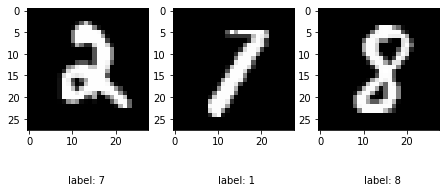

In [7]:
## That's all well and good, but let's take a look at some pictures as well!!
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1, 4, 1)
plt.text(9, 40, f"label: {labels[i1]}")
plt.imshow(images[34620], cmap='gray')
fig.add_subplot(1, 4, 2)
plt.text(10, 40, f"label: {labels[i2]}")
plt.imshow(images[i2], cmap='gray')
fig.add_subplot(1,4,3)
plt.text(10, 40, f"label: {labels[i3]}")
plt.imshow(images[i3], cmap='gray')
plt.show()

In [7]:
# Alright, that seems all good. Let's just save the data
# For the labels, we're just going to save them as a 1D array. This will come back to bite us in the butt later, but if we were # to transform these labels into vectors now, we'd miss out on a nice learning oppurtunity later on.

with open("./data/processed_training_labels.csv", 'w') as f:
    f.write(','.join(map(lambda x: str(x),labels)))

## A brief note here:
## The way I am storing images in this project is NOT SMART. We already have the wonderful 45mb file that we downloaded. When ## this writing loop is done, it will have created a ~105mb file on your machine. So why am I doing this?
## Well, the purpose of this is to learn. Many people are likely not used to reading in data as raw (or nearly raw) bytes. 
## maybe the byte reading up above was a little dicey for some of you. So I'm storing the data in a format that anyone with a rudimentary background in CS will know how to parse and play with: CSV. It's going to hurt our performance, but it may just help with understanding.

# Note -- I also am aware of my privledge here. Some machines may begin to struggle with a file this size. If that's the case, I'm sorry.

with open("./data/processed_training_images", 'w') as f:
    ## We'll store each image as a flat entry on a single line
    for img in images:
        f.write(','.join(map(lambda x: str(x), img.flatten())))
        f.write('\n')

In [144]:
#############################################################################################################################

In [149]:
# Starting with the easy stuff, parsing the image labels
with open("./data/t10k-labels-idx1-ubyte", 'rb') as label_file:
    # See http://yann.lecun.com/exdb/mnist/#:~:text=TRAINING%20SET%20IMAGE%20FILE%20(train%2Dimages%2Didx3%2Dubyte)%3A for full     #  schema
    # Basically, bytes [0,4) are magic number, [4,8) are the number of labels, and each byte after that is a label (0-9).
    label_file.seek(4)
    num_labels = label_file.read(4)
    num_labels = int.from_bytes(num_labels, "big")
    labels = []
    for _ in range(num_labels):
        label = int.from_bytes(label_file.read(1), "big")
        labels.append(label)
    
    assert len(labels) == num_labels  # Just to make sure we did everything right

In [150]:
with open("./data/t10k-images-idx3-ubyte", 'rb') as images_file:
    global num_images  # we'll use this later
    images_file.seek(4) # Skip the magic number
    num_images = int.from_bytes(images_file.read(4), "big")
    num_rows = int.from_bytes(images_file.read(4), "big")
    num_cols = int.from_bytes(images_file.read(4), "big")
    images = []
    for _ in range(num_images):
        img_bytes = list(images_file.read(num_rows*num_cols))
        img = np.array(img_bytes)
        img = np.reshape(img, (28,28))
        images.append(img)
    

In [151]:
with open("./data/processed_testing_labels.csv", 'w') as f:
    f.write(','.join(map(lambda x: str(x),labels)))

with open("./data/processed_testing_images", 'w') as f:
    ## We'll store each image as a flat entry on a single line
    for img in images:
        f.write(','.join(map(lambda x: str(x), img.flatten())))
        f.write('\n')